In [17]:
import pandas as pd 
# import matplotlib.pyplot as plt
# from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import os
import dask.dataframe as ddf
import matplotlib.pyplot as plt


import sys
sys.path.append("..")

from channeling_lib import AWS_file_loader, load_path

stations_str = ['Tom Joad','Rosanna','Bette Davis', 'Layla', 'Mrs Robinson']

TinyTag_str = ['CEB_1']

In [18]:
path = load_path()+'RawData/TinyTag/'

instrument_textbook_name = load_path()+'instrument_textbook_BLcourse_spring2025(BL instruments).csv'
instrument_textbook_data = pd.read_csv(instrument_textbook_name, encoding='latin1')

# Loading start and end times of Tinytag for calibration

In [19]:
instrument_textbook_data

,Station name,Category,Setup by group,Quantities measured,LAT (dec deg),LON (dec deg),elevation from GPS (masl),elevation from DEM (masl),Radiometer height(m),Th height (m),Anemometer height (m),CEB orientation (Tg),Setup time (UTC),Retrieval time (UTC),Maintenance start time (UTC),Maintenance duration (minutes),Comments,Unnamed: 17
0,Layla,AWS-P,3,"T, Ws, Wd, Tg, P",78.172686,16.010102,186 (NOT ACCURATE),28.2,NaN,1.820,2.09,NE,1/26/25 11:25,2/3/25 11:10,1/30/25 9:40,30.0,NaN,NaN
1,TH3,Tinytag,3,"T, Rh",78.181669,15.908088,181 (NOT ACCURATE),20.9,NaN,1.400,NaN,NaN,1/26/25 12:30,2/3/25 11:54,1/30/25 10:15,10.0,NaN,NaN
2,TH2,Tinytag,3,"T, Rh",78.212169,15.756418,160 (NOT ACCURATE),1.0,NaN,1.650,NaN,NaN,1/26/25 12:45,2/3/25 12:04,1/30/25 10:35,15.0,NaN,NaN
3,Tom Joad,AWS,3,"T, Ws, Wd, Tg",78.226178,15.650295,NaN,0.5,NaN,1.900,2.21,N,1/26/25 14:30,2/3/25 12:14,1/30/25 10:50,15.0,NaN,NaN
4,Rosanna,AWS-P,3,"T, Ws, Wd, Tg, P",78.239350,15.749290,NaN,1.4,NaN,1.680,2.05,NE,1/27/25 10:30,2/3/25 9:10,1/31/25 10:50,40.0,NaN,NaN
5,TH5,Tinytag,3,"T, Rh",78.223609,15.797014,NaN,3.6,NaN,1.650,NaN,NaN,1/27/25 11:10,2/3/25 9:44,1/31/25 12:17,6.0,NaN,NaN
6,Bette Davis,AWS,3,"T, Ws, Wd, Tg",78.213555,15.857184,53 (NOT ACCURATE),4.4,NaN,1.700,2.08,N,1/27/25 12:10,2/3/25 9:52,1/31/25 13:05,53.0,NaN,NaN
7,TH6,Tinytag,3,"T, Rh",78.197500,15.959215,72 (NOT ACCURATE),10.9,NaN,1.570,NaN,NaN,1/27/25 13:30,2/3/25 10:23,1/31/25 15:05,8.0,NaN,NaN
8,Mrs Robinson,AWS,3,"T, Ws, Wd, Tg",78.192157,16.029810,76 (NOT ACCURATE),17.3,NaN,1.780,2.09,W,1/27/25 13:40,2/3/25 10:37,1/31/25 16:00,30.0,NaN,NaN
9,TH1,TinyTag,1,"T, Rh",78.240911,15.354190,265 (NOT ACCURATE),27.5,NaN,1.490,NaN,NaN,1/27/25 10:58,2/3/25 12:48,NaN,NaN,NaN,tiny tag between fjord station and Björndalen


In [3]:
##### do not run yet #####
#cut out data that is not being used or messed around with

manual_times = {}


for station in stations_str:
    setup_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Station name'] == station, 'Setup time (UTC)'].values[0])

    maintenance_start_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Station name'] == station, 'Maintenance start time (UTC)'].values[0])

    maintenance_duration_idx = int(instrument_textbook_data.loc[instrument_textbook_data['Station name'] == station, 'Maintenance duration (minutes)'].values[0])

    retrieval_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Station name'] == station, 'Retrieval time (UTC)'].values[0])

    manual_times[station] = {
            'setup_time': setup_time_idx,
            'maintenance_start_time': maintenance_start_time_idx,
            'maintenance_duration': maintenance_duration_idx,
            'retrieval_time': retrieval_time_idx
        }

DateParseError: Unknown datetime string format, unable to parse: 1/26/2025  14:30:00 PM, at position 0

# Loading TinyTag Calibration data

The calibration data is stored in format:

- CEB_i_calibration_data

- THi_calibration_data

- TTi_calibration_data

Where i corresponds to the number of the TinyTag, i.e. the same number as the raw files

In [4]:
#function from unis github
def read_Tinytag(filename, sensor):
    '''
    Reads data from one or several data files from the Tinytag output files.

    Parameters:
    -------
    filename: str
        String with path to file(s)
        If several files shall be read, specify a string including UNIX-style wildcards
    sensor: str
        One of "TT", "TH" or "CEB"
    Returns
    -------
    df : pandas dataframe
        a pandas dataframe with time as index and the individual variables as columns.
    '''

    import dask.dataframe as ddf


    if sensor == "TT":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T_black", "T_white"], encoding = "ISO-8859-1")
    elif sensor == "TH":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T", "RH"], encoding = "ISO-8859-1")
    elif sensor == "CEB":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T"], encoding = "ISO-8859-1")
    else:
        assert False, 'Sensortype of Tinytag not known. Should be one of "TT", "TH" or "CEB".'

    df = df.compute()
    df.set_index("TIMESTAMP", inplace=True)

    for key in list(df.columns):
        if key == "RECORD":
            pass
        else:
            data = [float(i.split(" ")[0]) for i in df[key]]
            unit = df[key].iloc[0].split(" ")[1]
            if unit == "°C":
                unit = "degC"
            new_key = f"{key}_{unit}"

            df[new_key] = data

            df.drop(key, axis=1, inplace=True)

    return df

In [5]:
# Get all CEB_i folders inside TinyTag
folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('CEB_')]

# Dictionary to store the datasets
calibration_data = {}

# Loop through each CEB_i folder
for folder in folders:
    folder_path = os.path.join(path, folder)
    
    # Get all .txt files that start with "CEB_i_calibration_"
    files = [f for f in os.listdir(folder_path) if f.startswith(folder + "_calibration_") and f.endswith(".txt")]
    
    for file in files:
        file_path = os.path.join(folder_path, file)
        
        # Run the read_Tinytag function
        dataset = read_Tinytag(file_path, 'CEB')
        
        # Store the dataset in a dictionary using the folder name as the key
        calibration_data[f"{folder}_calibration_data"] = dataset

# Loop over the stored datasets and assign them as individual variables
for dataset_name in calibration_data.keys():
    globals()[dataset_name] = calibration_data[dataset_name]

In [6]:
# TH
folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('TH')]

# Dictionary to store the datasets
calibration_data = {}

for folder in folders:
    folder_path = os.path.join(path, folder)
    
    # Get all .txt files that start with "THi_calibration_"
    files = [f for f in os.listdir(folder_path) if f.startswith(folder + "_calibration_") and f.endswith(".txt")]
    
    for file in files:
        file_path = os.path.join(folder_path, file)
        
        # Run the read_Tinytag function
        dataset = read_Tinytag(file_path, 'TH')
        
        # Store the dataset in a dictionary using the folder name as the key
        calibration_data[f"{folder}_calibration_data"] = dataset

for dataset_name in calibration_data.keys():
    globals()[dataset_name] = calibration_data[dataset_name]

In [7]:
# TT
folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('TT')]

# Dictionary to store the datasets
calibration_data = {}

for folder in folders:
    folder_path = os.path.join(path, folder)
    
    # Get all .txt files that start with "TTi_calibration_"
    files = [f for f in os.listdir(folder_path) if f.startswith(folder + "_calibration_") and f.endswith(".txt")]
    
    for file in files:
        file_path = os.path.join(folder_path, file)
        
        # Run the read_Tinytag function
        dataset = read_Tinytag(file_path, 'TT')
        
        # Store the dataset in a dictionary using the folder name as the key
        calibration_data[f"{folder}_calibration_data"] = dataset

for dataset_name in calibration_data.keys():
    globals()[dataset_name] = calibration_data[dataset_name]

# Loading TinyTag data

In [29]:
# do not run yet!!####

# Get all CEB_i folders inside TinyTag
folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('CEB_')]

# Dictionary to store the datasets
calibration_data = {}

# Loop through each CEB_i folder
for folder in folders:
    folder_path = os.path.join(path, folder)
    
    # Get all .txt files that does not include "CEB_i_calibration_"
    # files = [f for f in os.listdir(folder_path) if f.startswith(folder + "_calibration_") and f.endswith(".txt")]
    files = [f for f in os.listdir(folder_path) if f.endswith(".txt") and "_calibration_" not in f]

    
    for file in files:
        file_path = os.path.join(folder_path, file)
        
        # Run the read_Tinytag function
        dataset = read_Tinytag(file_path, 'CEB')
        
        # Store the dataset in a dictionary using the folder name as the key
        calibration_data[f"{folder}_calibration_data"] = dataset

# Loop over the stored datasets and assign them as individual variables
for dataset_name in calibration_data.keys():
    globals()[dataset_name] = calibration_data[dataset_name]

In [16]:
CEB_1_calibration_data

,RECORD,T_degC
TIMESTAMP,,
2025-01-24 09:30:43,1,21.51
2025-01-24 09:31:43,2,22.31
2025-01-24 09:32:43,3,21.65
2025-01-24 09:33:43,4,21.22
2025-01-24 09:34:43,5,20.92
...,...,...
2025-01-25 15:36:43,1807,17.25
2025-01-25 15:37:43,1808,17.13
2025-01-25 15:38:43,1809,14.36


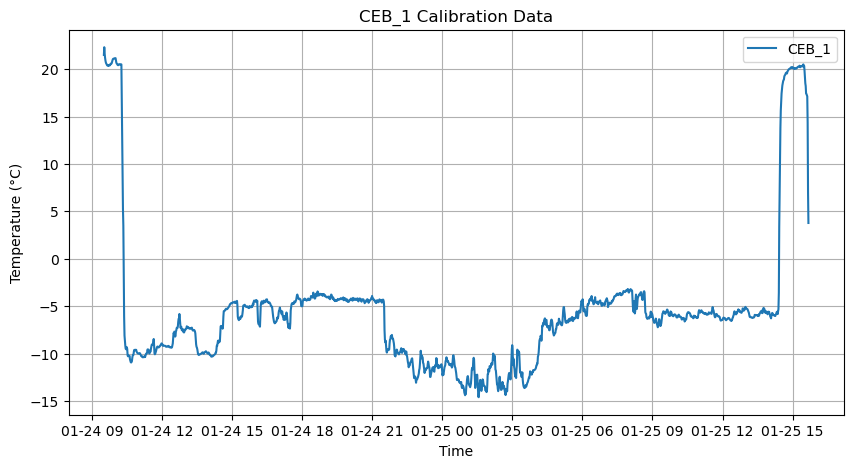

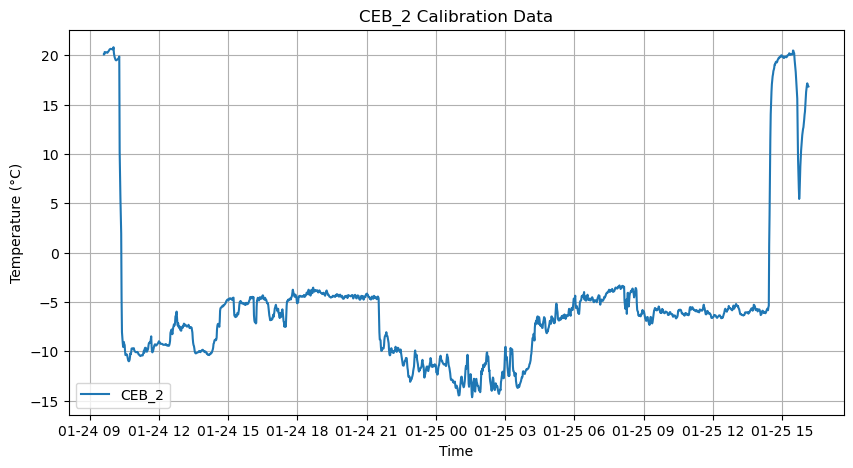

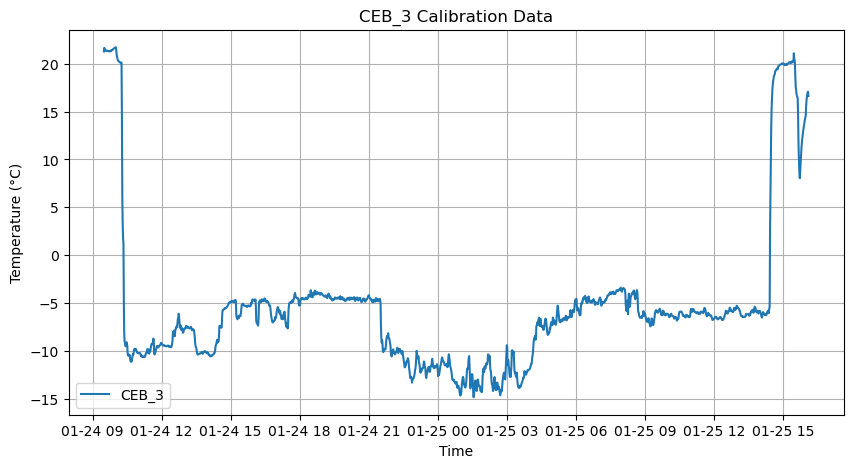

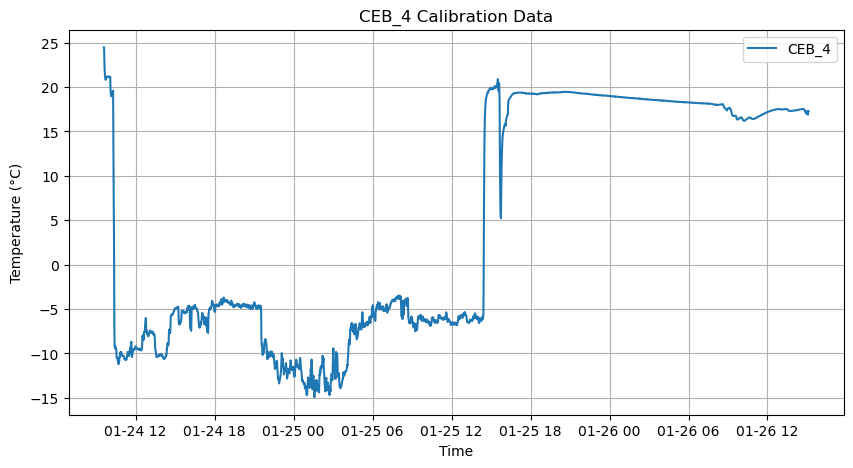

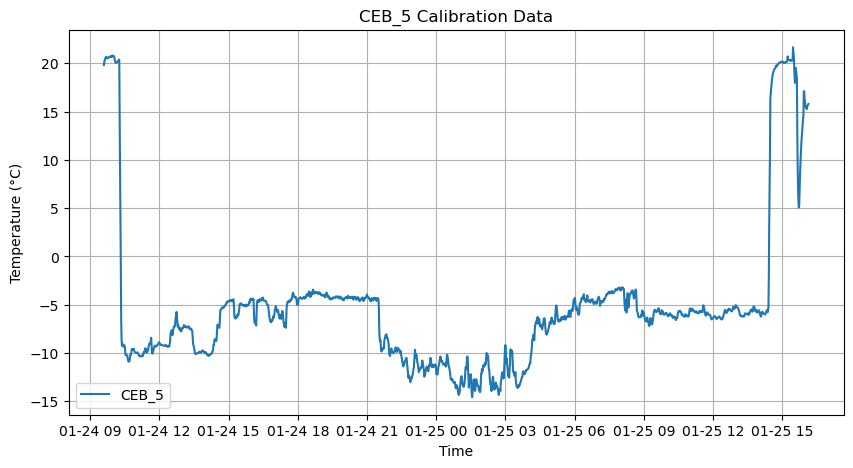

In [9]:

# List of CEB calibration data variables
ceb_data_stations = [CEB_1_calibration_data, CEB_2_calibration_data, CEB_3_calibration_data, CEB_4_calibration_data, CEB_5_calibration_data]

# Plot each CEB data station individually against time
for i, ceb_data in enumerate(ceb_data_stations, start=1):
    plt.figure(figsize=(10, 5))
    plt.plot(ceb_data.index, ceb_data['T_degC'], label=f'CEB_{i}')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.title(f'CEB_{i} Calibration Data')
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
# Remove seconds from the timestamps
CEB_1_trimmed.loc[:, 'TIMESTAMP_ROUNDED'] = CEB_1_trimmed.index.floor('min')
CEB_2_trimmed.loc[:, 'TIMESTAMP_ROUNDED'] = CEB_2_trimmed.index.floor('min')
CEB_3_trimmed.loc[:, 'TIMESTAMP_ROUNDED'] = CEB_3_trimmed.index.floor('min')
CEB_4_trimmed.loc[:, 'TIMESTAMP_ROUNDED'] = CEB_4_trimmed.index.floor('min')
CEB_5_trimmed.loc[:, 'TIMESTAMP_ROUNDED'] = CEB_5_trimmed.index.floor('min')

# Set the new rounded timestamp as the index
CEB_1_trimmed.set_index('TIMESTAMP_ROUNDED', inplace=True)
CEB_2_trimmed.set_index('TIMESTAMP_ROUNDED', inplace=True)
CEB_3_trimmed.set_index('TIMESTAMP_ROUNDED', inplace=True)
CEB_4_trimmed.set_index('TIMESTAMP_ROUNDED', inplace=True)
CEB_5_trimmed.set_index('TIMESTAMP_ROUNDED', inplace=True)

NameError: name 'CEB_1_trimmed' is not defined

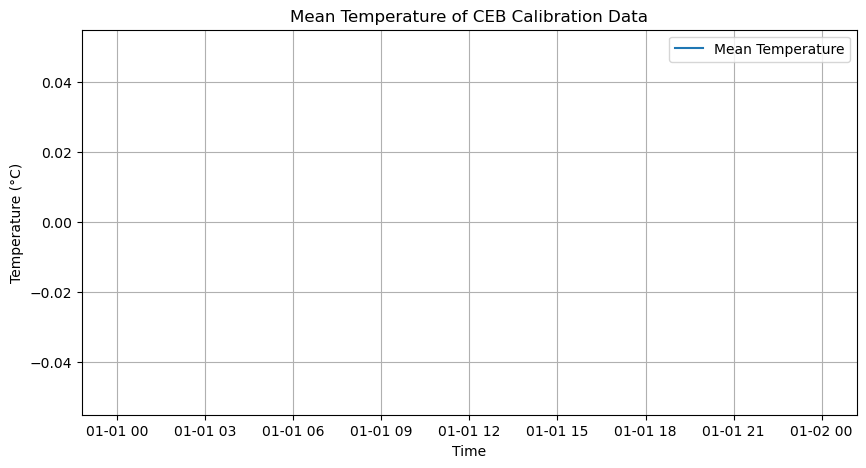

In [12]:
# Find the overlapping timeframe
start_time = max(CEB_1_calibration_data.index.min(), CEB_2_calibration_data.index.min(), CEB_3_calibration_data.index.min(), CEB_4_calibration_data.index.min(), CEB_5_calibration_data.index.min())
end_time = min(CEB_1_calibration_data.index.max(), CEB_2_calibration_data.index.max(), CEB_3_calibration_data.index.max(), CEB_4_calibration_data.index.max(), CEB_5_calibration_data.index.max())

# Trim each dataset to the overlapping timeframe
CEB_1_trimmed = CEB_1_calibration_data.loc[start_time:end_time]
CEB_2_trimmed = CEB_2_calibration_data.loc[start_time:end_time]
CEB_3_trimmed = CEB_3_calibration_data.loc[start_time:end_time]
CEB_4_trimmed = CEB_4_calibration_data.loc[start_time:end_time]
CEB_5_trimmed = CEB_5_calibration_data.loc[start_time:end_time]

# Calculate the mean of the trimmed datasets
mean_temperature = (CEB_1_trimmed['T_degC'] + CEB_2_trimmed['T_degC'] + CEB_3_trimmed['T_degC'] + CEB_4_trimmed['T_degC'] + CEB_5_trimmed['T_degC']) / 5

# Plot the mean values
plt.figure(figsize=(10, 5))
plt.plot(mean_temperature.index, mean_temperature, label='Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Mean Temperature of CEB Calibration Data')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
# Remove seconds from the timestamps
TH2_calibration_data.index = TH2_calibration_data.index.strftime('%d %b %Y %H:%M')
TH3_calibration_data.index = TH3_calibration_data.index.strftime('%d %b %Y %H:%M')
TH5_calibration_data.index = TH5_calibration_data.index.strftime('%d %b %Y %H:%M')
TH6_calibration_data.index = TH6_calibration_data.index.strftime('%d %b %Y %H:%M')
TH8_calibration_data.index = TH8_calibration_data.index.strftime('%d %b %Y %H:%M')
TT13_calibration_data.index = TT13_calibration_data.index.strftime('%d %b %Y %H:%M')
TT14_calibration_data.index = TT14_calibration_data.index.strftime('%d %b %Y %H:%M')
TT15_calibration_data.index = TT15_calibration_data.index.strftime('%d %b %Y %H:%M')
TT16_calibration_data.index = TT16_calibration_data.index.strftime('%d %b %Y %H:%M')
TT17_calibration_data.index = TT17_calibration_data.index.strftime('%d %b %Y %H:%M')
TT18_calibration_data.index = TT18_calibration_data.index.strftime('%d %b %Y %H:%M')
TT1_calibration_data.index = TT1_calibration_data.index.strftime('%d %b %Y %H:%M')
TT2_calibration_data.index = TT2_calibration_data.index.strftime('%d %b %Y %H:%M')
TT3_calibration_data.index = TT3_calibration_data.index.strftime('%d %b %Y %H:%M')
TT4_calibration_data.index = TT4_calibration_data.index.strftime('%d %b %Y %H:%M')
TT5_calibration_data.index = TT5_calibration_data.index.strftime('%d %b %Y %H:%M')
TT6_calibration_data.index = TT6_calibration_data.index.strftime('%d %b %Y %H:%M')
TT7_calibration_data.index = TT7_calibration_data.index.strftime('%d %b %Y %H:%M')
TT9_calibration_data.index = TT9_calibration_data.index.strftime('%d %b %Y %H:%M')
"""
# List of all calibration data variables
calibration_data_vars = [
    TH2_calibration_data, TH3_calibration_data, TH5_calibration_data, TH6_calibration_data, TH8_calibration_data,
    TT13_calibration_data, TT14_calibration_data, TT15_calibration_data, TT16_calibration_data, TT17_calibration_data,
    TT18_calibration_data, TT1_calibration_data, TT2_calibration_data, TT3_calibration_data, TT4_calibration_data,
    TT5_calibration_data, TT6_calibration_data, TT7_calibration_data, TT9_calibration_data,
    CEB_1_calibration_data, CEB_2_calibration_data, CEB_3_calibration_data, CEB_4_calibration_data, CEB_5_calibration_data
]

# Loop through each calibration data variable and remove seconds from the timestamps
for data in calibration_data_vars:
    data.index = data.index.strftime('%d %b %Y %H:%M')


Total timestamps before alignment: 11838
Unique timestamps: 11838
Total timestamps after alignment: 5510


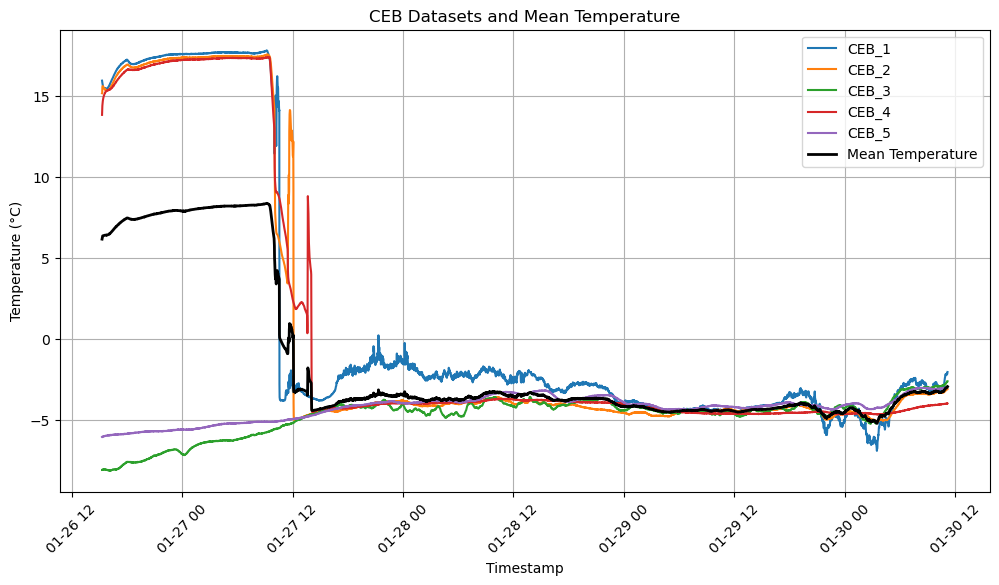

In [20]:

"""
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
"""

# Define the path to the Tinytag directory
tinytag_dir = 'C:/Users/rebec/OneDrive - Herbst GmbH/Pictures/Dokumente/AGF350_Svalbard/BL_Group3_wind_chanelling/Data/RawData/TinyTag'

# Find all directories that start with 'CEB_'
ceb_dirs = [d for d in os.listdir(tinytag_dir) if os.path.isdir(os.path.join(tinytag_dir, d)) and d.startswith('CEB_')]

# Initialize a dictionary to store dataframes
dataframes = {}

# Loop through each CEB directory and read the txt file inside
for ceb_dir in ceb_dirs:
    txt_files = glob.glob(os.path.join(tinytag_dir, ceb_dir, '*.txt'))
    
    if txt_files:
        file_path = txt_files[0]

        # Read the file while skipping metadata (assume first 5 rows are metadata)
        df = pd.read_csv(file_path, delimiter='\t', skiprows=5, names=["Index", "Timestamp", "Temperature"], encoding='ISO-8859-1')

        # Convert Timestamp to datetime format
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='%d %b %Y %H:%M:%S')

        # Truncate seconds immediately
        df["Timestamp"] = df["Timestamp"].dt.floor("min")

        # Remove degree symbol and convert temperature to float
        df["Temperature"] = df["Temperature"].str.replace("°C", "").astype(float)

        # Set Timestamp as the index
        df = df.set_index("Timestamp")

        # Ensure the dataset has continuous minute-based timestamps
        df = df.asfreq("min")  # Set a minutely time index
        df = df.ffill()  # Fill small gaps if timestamps are missing

        # Store the DataFrame in dictionary
        dataframes[ceb_dir] = df["Temperature"]

# Merge all datasets into a single DataFrame (aligned by minute timestamps)
all_data = pd.concat(dataframes, axis=1)

# Check timestamps before alignment
print(f"\nTotal timestamps before alignment: {len(all_data)}")
print(f"Unique timestamps: {all_data.index.nunique()}")

# Drop rows where any dataset is missing
all_data = all_data.dropna()

# Check timestamps after alignment
print(f"Total timestamps after alignment: {len(all_data)}")

# Ensure there are still overlapping timestamps
if all_data.empty:
    raise ValueError("No overlapping timestamps remain after aligning datasets!")

# Compute the mean temperature across all stations at each timestamp
mean_temp = all_data.mean(axis=1)

# Plot all CEB datasets together
plt.figure(figsize=(12, 6))
for station in all_data.columns:
    plt.plot(all_data.index, all_data[station], label=f"{station}")

# Add the mean temperature to the plot
plt.plot(mean_temp.index, mean_temp, label="Mean Temperature", color="black", linewidth=2)

plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.title("CEB Datasets and Mean Temperature")
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()



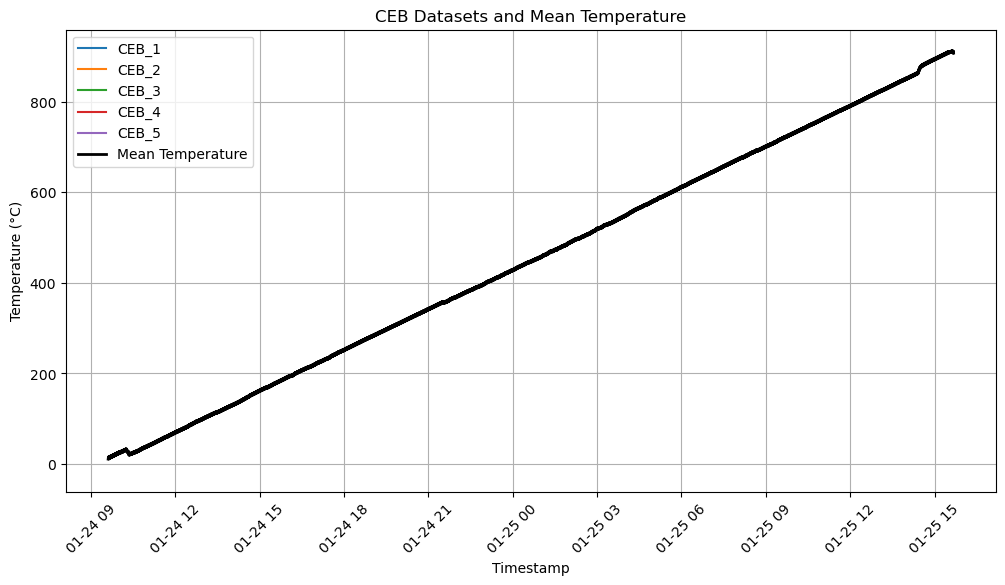

In [ ]:
"""
#import matplotlib.pyplot as plt

# List of CEB calibration data variables
ceb_data_stations = [CEB_1_trimmed, CEB_2_trimmed, CEB_3_trimmed, CEB_4_trimmed, CEB_5_trimmed]

# Combine all CEB datasets into a single DataFrame
combined_df = pd.concat(ceb_data_stations, axis=1, keys=['CEB_1', 'CEB_2', 'CEB_3', 'CEB_4', 'CEB_5'])

# Calculate the mean temperature per timestep
mean_temp = combined_df.mean(axis=1)

# Plot all CEB datasets together
plt.figure(figsize=(12, 6))
for station in combined_df.columns.levels[0]:
    plt.plot(combined_df[station].index, combined_df[station]['T_degC'], label=station)

# Add the mean temperature to the plot
plt.plot(mean_temp.index, mean_temp, label="Mean Temperature", color="black", linewidth=2)

plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.title("CEB Datasets and Mean Temperature")
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()
"""